# Mouse dynamics from stroke point of view

First we collect mouse movement raw data on Windows from 5 users. This data is processed by another program in C++ to find strokes and calculate some features on them. A stroke is continuous mouse movement delimited by times when we stop receiving mouse move events. Intuitively, it should correspond to the user moving the mouse from point A to B and then stopping.

Most of our analysis code is in a Python file called analysis.py organized in classes by topic. We import that and then just call methods to demonstrate.

In this method, we take the strokes and normalize their length to 100 so that we can then lay them over each other and compare, interpolating the shorter strokes and resampling the longer strokes. We then look at the speed of mouse movement at each of these 100 points, plotting it in a line plot.

In [4]:
import os, sys
import numpy as np

sys.path.append('.')
import analysis as ann
%matplotlib inline

The analysis library stores some well-known datafile locations based on the machine, to add yours, edit the `load_bymachine` method.

In [3]:
reload(ann)
csdsg = ann.CombinedSetup.load_bymachine(2, massage=True)

removed 2506


In [58]:
# split data to testing, learning halves
csdsg.random = False
csdsg.ratio = 0.5
csdsg.partition()

Before starting the analysis of strokes, we select a subset by their length and then split the whole dataset by the user who generated them. We can use a simple method call to do all that.

In [73]:
sel = ann.SelectStrokes(csdsg.all_data['strokes'], csdsg.sessions)
sel.max_len = 30
sel.min_len = 4
sel.divide_to_sessions()

Now we can plot the data. We plot the mouse movement speed (feature '`v`') from 0 to 100 (resampled) for each stroke in the same image. Instead of looking at the individual lines, however, we generate a "heatmap" to see which areas have the most lines passing through them. The plot is in fact a 2D histogram of speeds during the "lifetime" of a stroke. Over the heatmap we plot the mean (pink), median (white), mean +- sd (black) values in each column (0-100) connected by a line. 

The code accepts some parameters, `key` is one of `v, vd, th, w, c, cs` which are different features of the stroke (speed, derivative of speed, direction of movement, derivative of direction, curvature, curvature2). `yrange_scale` is the scale of Y plot range needed because sometimes we are getting extreme values that cause the plot to "zoom out".

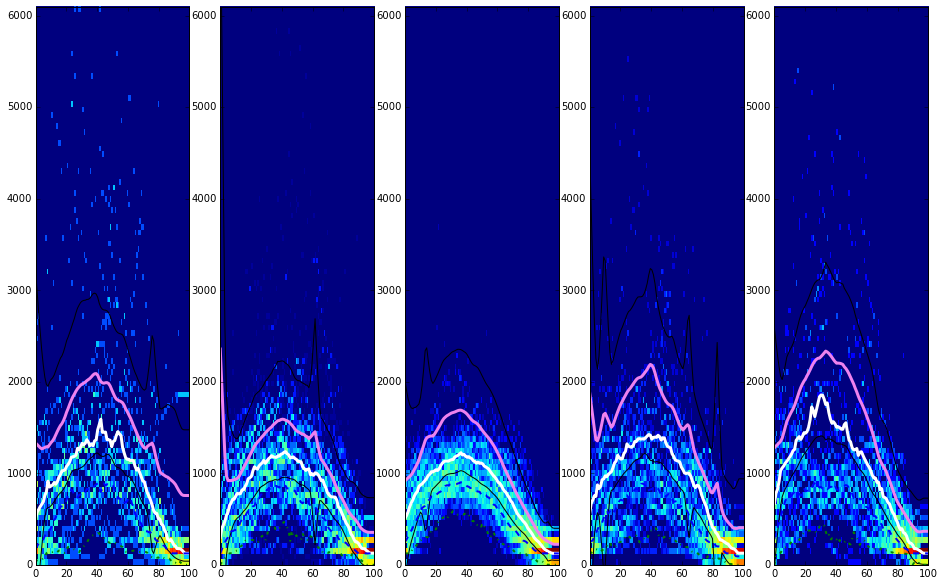

In [81]:
reload(ann)
vhist = ann.SpeedsHistogram()
vhist.key = 'v'
vhist.yrange_scale = 0.07
vhist.load_dct(sel.dat, sel.sess_mapping)
vhist.calc_means()

vhist.prepare_plot((16, 10))
vhist.plot_hist()
vhist.plot_line()


We can also plot the actual lines.

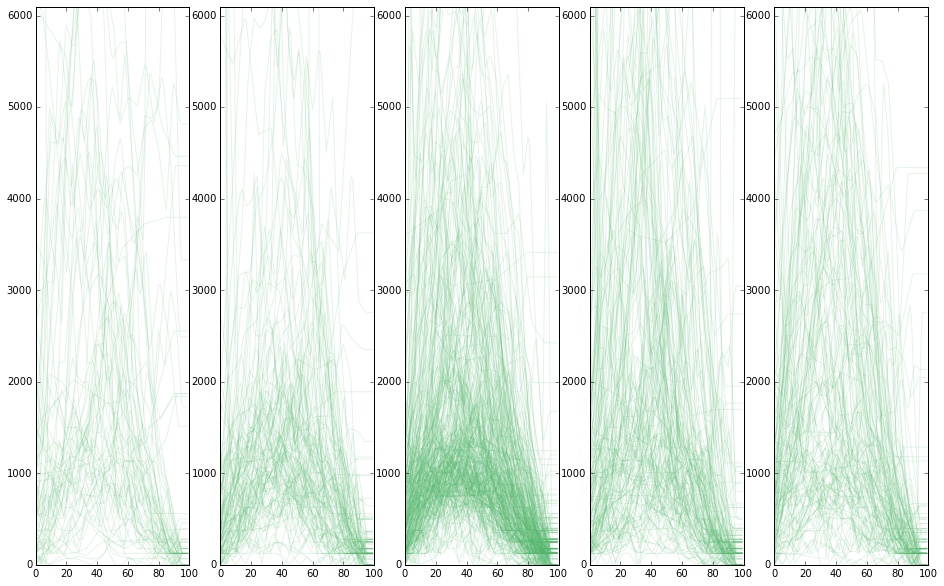

In [68]:
vhist.prepare_plot((16, 10))
vhist.plot_samples_lines()

We can now compare this picture between a testing and learning data subsets. The learning dataset is the first half of our data, testing dataset is the second half. We instantiate another object to run these calculations

In [83]:
ev = ann.EvaluateStrokeSpeedsMethod(sel, csdsg)
ev.hs_learning.yrange_scale = ev.hs_testing.yrange_scale = 0.1

ev.calc()

# a bit of a hack
ev.hs_learning.Range = ev.hs_testing.Range

In the plot below, we draw the medians from the different users. The gray plots "in the background" are the learning datasets for all 5 users (same in each subplot). The blue line is the learning dataset for the current user (it's therefore one of the gray lines) and the red line is the testing data for the same user.

We would therefore like to have the blue and red line very similar to each other and at the same time quite different from the gray lines.

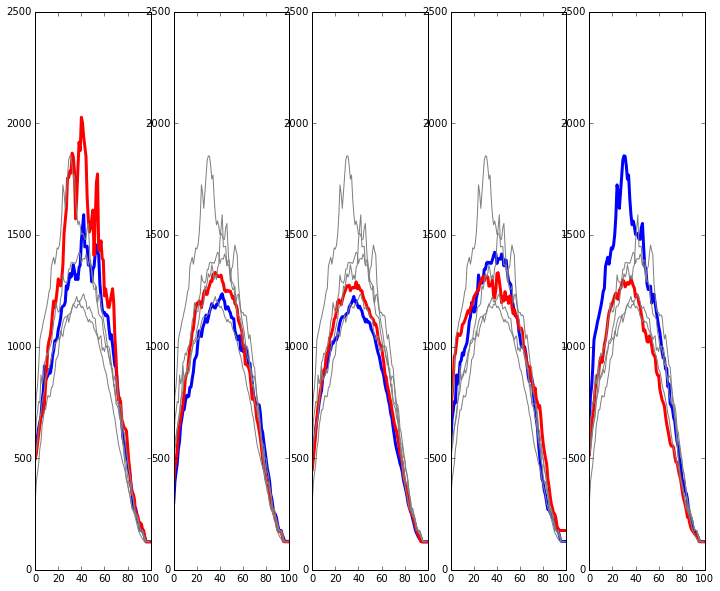

In [76]:
ev.plot_comparisons()

We can also repeat the plot above with the data split in two halves for learning and testing purposes.

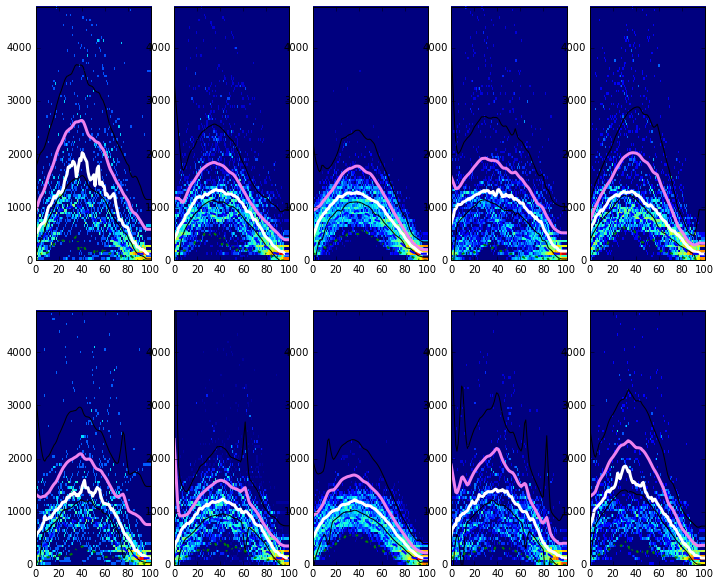

In [84]:
ev.plot_comparison_hists()

Now to increase accuracy, there's one trick we can use. We first segment the whole dataset by stroke lengths into 5 groups and then run all calculations in each group separately. This way we only compare strokes that are more similar to each other (because they have approximately the same length).

To be more precise, the segmentation is using stroke length and also a flag whether there was a click immediately after the stroke (we assume that strokes without a click are more random or unintentional).

(<matplotlib.figure.Figure at 0x1122aaa50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x116bf1510>)

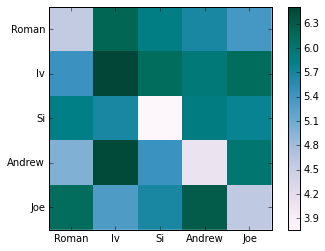

In [78]:
reload(ann)
sgc = ann.SegmentedVHistCompare(csdsg.sessions)
comp = sgc.compare_new(csdsg.first, csdsg.second, csdsg.slabels_by())
comp_sum = sgc.sum_results(comp)
ann.ParzenMethod.show_match(comp_sum)

What we got here is the final rating of our method. It illustrates the difference score between the testing and learning subsets for each user. For example in the last row of Joe we see it's dark in Andrew's column which means that Joe's testing data does not match Andrew's learning data. On the other hand, the bottom right corner shows that Joe's testing data is quite similar to Joe's learning data which is a good result. Note that the matrix is not symmetric, the cell for (Andrew, Joe) is different from (Joe,Andrew) because in one case we use Joe's testing data and in the other case Joe's learning data.